In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error as mape,mean_absolute_error as mae
from keras import optimizers

# Prepare Data

In [2]:
cloud_cover = pd.read_csv('../prophet_ver2/mergefile_drop_na.csv',skipinitialspace = True)
cloud_cover = cloud_cover.rename(columns={"timestamp":"DateTime"})
cloud_cover

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2975,2021-12-16 13:40:00,667.8462,32.0638,38.0598,1.7466,0.185000
2976,2021-12-16 13:45:00,655.7560,32.3906,37.1100,1.7442,0.182000
2977,2021-12-16 13:50:00,647.5236,32.3444,37.1282,1.7116,0.180000
2978,2021-12-16 13:55:00,635.4336,32.3944,37.2276,1.7612,0.169000


In [3]:
def lags_train_test(datax, datay, data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(datax[i-lags:i])
		y.append(datay[i])
	return np.array(X), np.array(y)

In [4]:
def Xtrain_ytrain(train,test,lags):
    sc = MinMaxScaler()
    train_x = sc.fit_transform(train)
    sc1 = MinMaxScaler()
    train_y = sc1.fit_transform(train[['cloud_cover']])
    # train
    X_train, y_train = lags_train_test(train_x,train_y, train, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    columns = test[['Eeg','Temperature','RH','Windspeed','cloud_cover']]
    dataset_total = pd.concat(([train,test]), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = pd.DataFrame(inputs, columns=columns.columns)
    test_x = sc.transform(inputs)
    test_y = sc1.transform(inputs[['cloud_cover']])
    # test
    X_test, y_test = lags_train_test(test_x,test_y, inputs, lags)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc1

In [5]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [6]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# Train/Test Model

In [8]:
train = cloud_cover[cloud_cover['DateTime'] < '2021-12-16 00:00:00']
test = cloud_cover[cloud_cover['DateTime'] >= '2021-12-16 00:00:00']

print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (2921, 6)
Test Shape (59, 6)


In [9]:
train

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2916,2021-12-15 16:35:00,199.7822,29.7842,57.2676,1.6910,0.245000
2917,2021-12-15 16:40:00,182.6936,29.6908,56.1350,1.6476,0.214000
2918,2021-12-15 16:45:00,165.2176,29.6822,56.8298,1.7884,0.311000
2919,2021-12-15 16:50:00,147.5764,29.5512,57.3708,1.6884,0.250000


In [10]:
test

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover
2921,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111
2922,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094
2923,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112
2924,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123
2925,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136
2926,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154
2927,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161
2928,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156
2929,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198
2930,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281


In [11]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

## Lag 5

In [12]:
# X_train, y_train, X_test and y_test
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

X_train Shape : (2916, 5, 5)
y_train Shape : (2916, 1)
X_test Shape :  (59, 5, 5)
y_test Shape :  (59, 1)


### Add frist layer: units = 50 and Add Dropout = 0.1

In [13]:
model_1 = Sequential()
model_1.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
model_1.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_1.compile(optimizer = opt, loss = 'mean_squared_error')
hist = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
92/92 [==============================] - 4s 14ms/step - loss: 0.0268 - val_loss: 0.0162
Epoch 2/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0151
Epoch 3/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0070 - val_loss: 0.0123
Epoch 4/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0109
Epoch 5/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 6/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 7/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 8/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 9/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 10/10
92/92 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0099


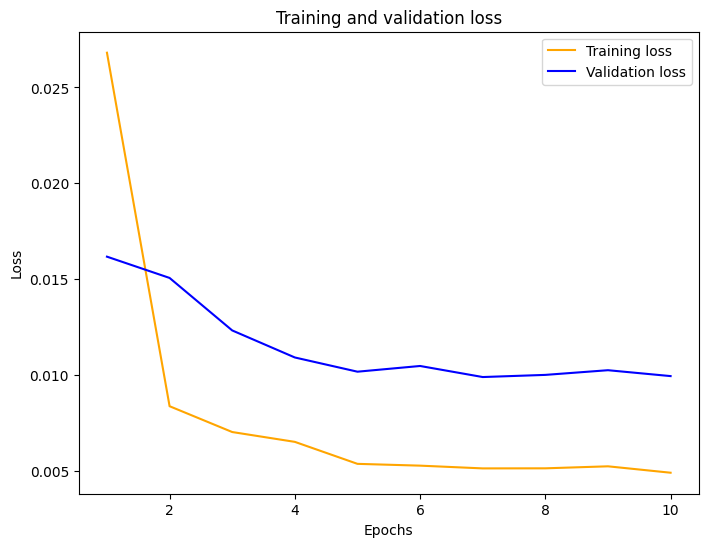

In [14]:
plot_curve(hist)

In [15]:
predict_scaled = model_1.predict(X_test)
predict = sc.inverse_transform(predict_scaled)
predict

2/2 [==============================] - 1s 6ms/step


array([[0.29335883],
       [0.12438456],
       [0.08646622],
       [0.10082087],
       [0.11168151],
       [0.12449206],
       [0.1498872 ],
       [0.15304515],
       [0.1493063 ],
       [0.18766087],
       [0.26116234],
       [0.3398109 ],
       [0.3184139 ],
       [0.2906203 ],
       [0.25015712],
       [0.28749695],
       [0.30882764],
       [0.43120825],
       [0.29396376],
       [0.5710354 ],
       [0.69799435],
       [0.73063415],
       [0.7824432 ],
       [0.24456938],
       [0.20375803],
       [0.20657842],
       [0.15740782],
       [0.162138  ],
       [0.15278082],
       [0.15346913],
       [0.1453834 ],
       [0.14941937],
       [0.14249714],
       [0.13146108],
       [0.12839222],
       [0.15297262],
       [0.16303594],
       [0.16707   ],
       [0.16422771],
       [0.17092314],
       [0.16407444],
       [0.16618285],
       [0.16084805],
       [0.14232995],
       [0.15558322],
       [0.16634038],
       [0.17011495],
       [0.167

In [16]:
train0 = train.copy()
test0 = test.copy()

In [17]:
train0.reset_index(inplace=True)
test0.reset_index(inplace=True)

In [18]:
test0['LSTM'] = predict
test0

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.293359
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.124385
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.086466
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.100821
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.111682
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.124492
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.149887
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.153045
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.149306
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.187661


In [19]:
plot_test(train0,test0)

In [20]:
lstm_mae_error = mae(test0["cloud_cover"], test0["LSTM"])
lstm_mape_error = mape(test0["cloud_cover"], test0["LSTM"])
lstm_mse_error = mean_squared_error(test0['cloud_cover'], test0['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test0["cloud_cover"], test0["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error)
print('MAPE Error :  %.5f'%lstm_mape_error)
print('MSE Error : %.5f'%lstm_mse_error)
print('RMSE Error :  %.5f'%lstm_rmse_error)

MAE Error :  0.04297
MAPE Error :  0.18585
MSE Error : 0.00983
RMSE Error :  0.09917


---

## Lag 10

In [21]:
# X_train, y_train, X_test and y_test
X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train,test,10)

X_train Shape : (2911, 10, 5)
y_train Shape : (2911, 1)
X_test Shape :  (59, 10, 5)
y_test Shape :  (59, 1)


### Add frist layer units = 50 batch size 32  epochs 10

In [22]:
model_2 = Sequential()
model_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1],X_train1.shape[2])))
model_2.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_2.compile(optimizer = opt, loss = 'mean_squared_error')
hist1 = model_2.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 10, batch_size = 32)

Epoch 1/10
91/91 [==============================] - 3s 12ms/step - loss: 0.0191 - val_loss: 0.0166
Epoch 2/10
91/91 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0124
Epoch 3/10
91/91 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0109
Epoch 4/10
91/91 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 5/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 6/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 7/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 8/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 9/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 10/10
91/91 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0107


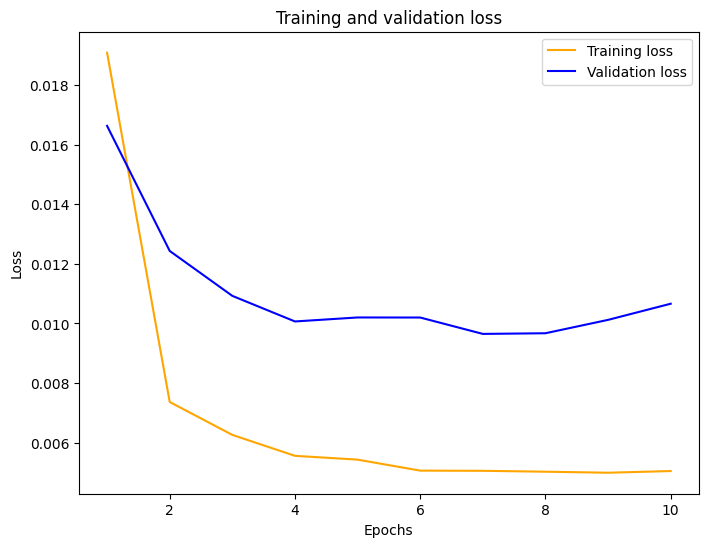

In [23]:
plot_curve(hist1)

In [24]:
predict_scaled1 = model_2.predict(X_test1)
predict1 = sc1.inverse_transform(predict_scaled1)

2/2 [==============================] - 1s 4ms/step


In [25]:
test1 = test.copy()
train1 = train.copy()

In [26]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [27]:
test1['LSTM'] = predict1
test1

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.356166
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.159281
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.118053
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.135425
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.146494
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.158931
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.182997
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.188282
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.184465
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.221925


In [28]:
plot_test(train1,test1)

In [29]:
lstm_mae_error1 = mae(test1["cloud_cover"], test1["LSTM"])
lstm_mape_error1 = mape(test1["cloud_cover"], test1["LSTM"])
lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
lstm_rmse_error1 = mean_squared_error(test1["cloud_cover"], test1["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error1)
print('MAPE Error :  %.5f'%lstm_mape_error1)
print('MSE Error : %.5f'%lstm_mse_error1)
print('RMSE Error :  %.5f'%lstm_rmse_error1)

MAE Error :  0.05809
MAPE Error :  0.29477
MSE Error : 0.01056
RMSE Error :  0.10274


---

## Lag 15

In [30]:
# X_train, y_train, X_test and y_test
X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train,test,15)

X_train Shape : (2906, 15, 5)
y_train Shape : (2906, 1)
X_test Shape :  (59, 15, 5)
y_test Shape :  (59, 1)


### Optimizer adam first layer 100 batch size 32 epochs 10 

In [31]:
model_3 = Sequential()
model_3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train2.shape[1],X_train2.shape[2])))
model_3.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_3.compile(optimizer = opt, loss = 'mean_squared_error')
hist2 = model_3.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32)

Epoch 1/10
91/91 [==============================] - 4s 16ms/step - loss: 0.0238 - val_loss: 0.0164
Epoch 2/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0084 - val_loss: 0.0135
Epoch 3/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0069 - val_loss: 0.0115
Epoch 4/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0058 - val_loss: 0.0105
Epoch 5/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0098
Epoch 6/10
91/91 [==============================] - 1s 7ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 7/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 8/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0109
Epoch 9/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0114
Epoch 10/10
91/91 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0095


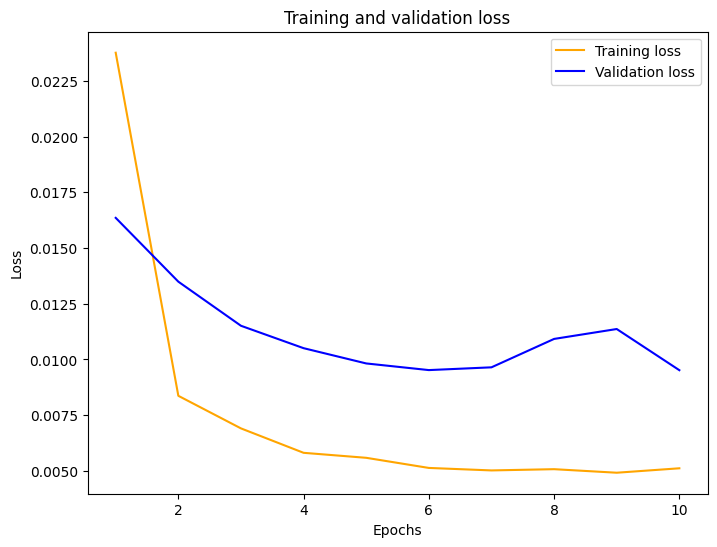

In [32]:
plot_curve(hist2)

In [33]:
predict_scaled2 = model_3.predict(X_test2)
predict2 = sc2.inverse_transform(predict_scaled2)

2/2 [==============================] - 1s 4ms/step


In [34]:
train2 = train.copy()
test2 = test.copy()

In [35]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [36]:
test2['LSTM'] = predict2
test2

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.338338
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.148871
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.103587
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.118994
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.131422
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.144058
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.168369
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.173330
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.168203
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.207137


In [37]:
plot_test(train2,test2)

In [38]:
lstm_mae_error2 = mae(test2["cloud_cover"], test2["LSTM"])
lstm_mape_error2 = mape(test2["cloud_cover"], test2["LSTM"])
lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
lstm_rmse_error2 = mean_squared_error(test2["cloud_cover"], test2["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error2)
print('MAPE Error :  %.5f'%lstm_mape_error2)
print('MSE Error : %.5f'%lstm_mse_error2)
print('RMSE Error :  %.5f'%lstm_rmse_error2)

MAE Error :  0.04590
MAPE Error :  0.20864
MSE Error : 0.00942
RMSE Error :  0.09706


---

## Lag 20

In [39]:
# X_train, y_train, X_test and y_test
X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train,test,20)

X_train Shape : (2901, 20, 5)
y_train Shape : (2901, 1)
X_test Shape :  (59, 20, 5)
y_test Shape :  (59, 1)


### Optimizer adam first layer 50 batch size 32 epochs 10 lr0.005

In [40]:
model_4 = Sequential()
model_4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1],X_train3.shape[2])))
model_4.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_4.compile(optimizer = opt, loss = 'mean_squared_error')
hist3 = model_4.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32)

Epoch 1/10
91/91 [==============================] - 5s 19ms/step - loss: 0.0274 - val_loss: 0.0155
Epoch 2/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0086 - val_loss: 0.0144
Epoch 3/10
91/91 [==============================] - 1s 11ms/step - loss: 0.0070 - val_loss: 0.0113
Epoch 4/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0059 - val_loss: 0.0109
Epoch 5/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 6/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 7/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 8/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 9/10
91/91 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 10/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.0099


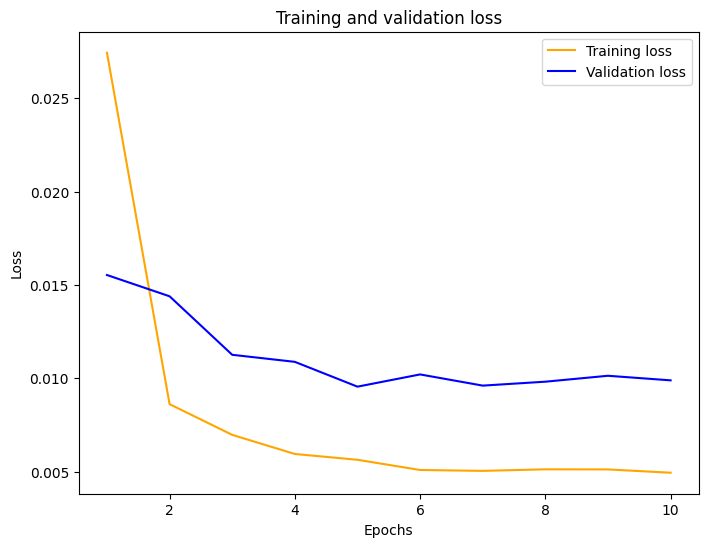

In [41]:
plot_curve(hist3)

In [42]:
predict_scaled3 = model_4.predict(X_test3)
predict3 = sc3.inverse_transform(predict_scaled3)

2/2 [==============================] - 1s 11ms/step


In [43]:
train3 = train.copy()
test3 = test.copy()

In [44]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [45]:
test3['LSTM'] = predict3
test3

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.312308
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.133458
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.090929
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.102780
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.112811
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.127206
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.153813
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.160283
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.158485
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.198787


In [46]:
plot_test(train3,test3)

In [47]:
lstm_mae_error3 = mae(test3["cloud_cover"], test3["LSTM"])
lstm_mape_error3 = mape(test3["cloud_cover"], test3["LSTM"])
lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
lstm_rmse_error3 = mean_squared_error(test3["cloud_cover"], test3["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error3)
print('MAPE Error :  %.5f'%lstm_mape_error3)
print('MSE Error : %.5f'%lstm_mse_error3)
print('RMSE Error :  %.5f'%lstm_rmse_error3)

MAE Error :  0.04784
MAPE Error :  0.22393
MSE Error : 0.00979
RMSE Error :  0.09893


---

## Lag 25

In [48]:
# X_train, y_train, X_test and y_test
X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train,test,25)

X_train Shape : (2896, 25, 5)
y_train Shape : (2896, 1)
X_test Shape :  (59, 25, 5)
y_test Shape :  (59, 1)


### Optimizer adam first layer 100 batch size 32 learning rate 0.005 epochs 20 

In [49]:
model_5 = Sequential()
model_5.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train4.shape[1],X_train4.shape[2])))
model_5.add(Dense(units = 1))
model_5.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist4 = model_5.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 20, batch_size = 32)

Epoch 1/20
91/91 [==============================] - 5s 22ms/step - loss: 0.0291 - val_loss: 0.0203
Epoch 2/20
91/91 [==============================] - 1s 14ms/step - loss: 0.0116 - val_loss: 0.0183
Epoch 3/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0097 - val_loss: 0.0160
Epoch 4/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0083 - val_loss: 0.0145
Epoch 5/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0075 - val_loss: 0.0130
Epoch 6/20
91/91 [==============================] - 1s 15ms/step - loss: 0.0066 - val_loss: 0.0159
Epoch 7/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0108
Epoch 8/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0061 - val_loss: 0.0117
Epoch 9/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 10/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0057 - val_loss: 0.0111
Epoch 11/

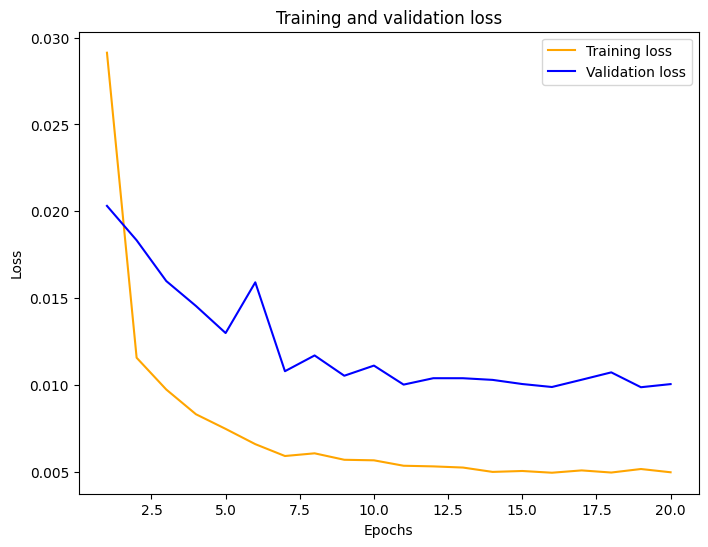

In [50]:
plot_curve(hist4)

In [51]:
predict_scaled4 = model_5.predict(X_test4)
predict4 = sc4.inverse_transform(predict_scaled4)

2/2 [==============================] - 1s 6ms/step


In [52]:
train4 = train.copy()
test4 = test.copy()

In [53]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [54]:
test4['LSTM'] = predict4
test4

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.311712
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.132673
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.082481
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.097414
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.109439
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.125693
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.152463
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.153875
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.151871
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.191253


In [55]:
plot_test(train4,test4)

In [56]:
lstm_mae_error4 = mae(test4["cloud_cover"], test4["LSTM"])
lstm_mape_error4 = mape(test4["cloud_cover"], test4["LSTM"])
lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
lstm_rmse_error4 = mean_squared_error(test4["cloud_cover"], test4["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error4)
print('MAPE Error :  %.5f'%lstm_mape_error4)
print('MSE Error : %.5f'%lstm_mse_error4)
print('RMSE Error :  %.5f'%lstm_rmse_error4)

MAE Error :  0.04536
MAPE Error :  0.20317
MSE Error : 0.00994
RMSE Error :  0.09971


---

## Lag 30

In [57]:
# X_train, y_train, X_test and y_test
X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train,test,30)

X_train Shape : (2891, 30, 5)
y_train Shape : (2891, 1)
X_test Shape :  (59, 30, 5)
y_test Shape :  (59, 1)


### Add frist layer units = 50 batch size 32  epochs 10

In [58]:
model_6 = Sequential()
model_6.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train5.shape[1],X_train5.shape[2])))
model_6.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.05)
model_6.compile(optimizer = opt, loss = 'mean_squared_error')
hist5 = model_6.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 20, batch_size = 32)

Epoch 1/20
91/91 [==============================] - 6s 26ms/step - loss: 0.1430 - val_loss: 0.0114
Epoch 2/20
91/91 [==============================] - 1s 15ms/step - loss: 0.0060 - val_loss: 0.0129
Epoch 3/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0101
Epoch 4/20
91/91 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0103
Epoch 5/20
91/91 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 6/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.0197
Epoch 7/20
91/91 [==============================] - 1s 13ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 8/20
91/91 [==============================] - 1s 14ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 9/20
91/91 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0102
Epoch 10/20
91/91 [==============================] - 1s 14ms/step - loss: 0.0056 - val_loss: 0.0105
Epoch 11/

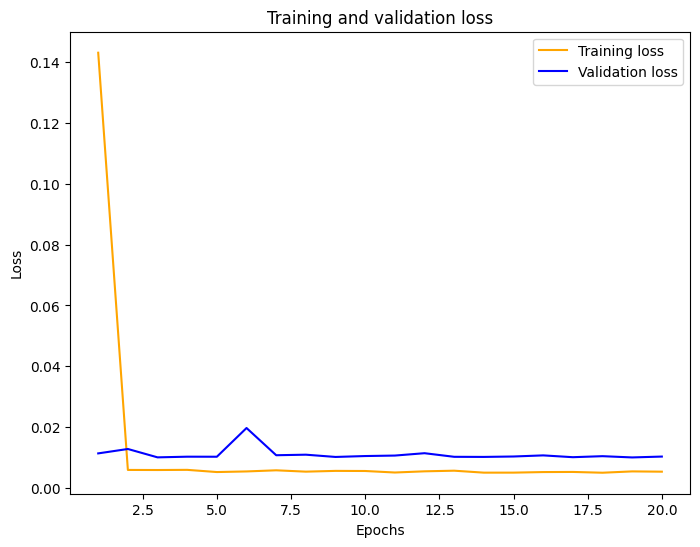

In [59]:
plot_curve(hist5)

In [60]:
predict_scaled5 = model_6.predict(X_test5)
predict5 = sc5.inverse_transform(predict_scaled5)

2/2 [==============================] - 1s 7ms/step


In [61]:
train5 = train.copy()
test5 = test.copy()

In [62]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [63]:
test5['LSTM'] = predict5
test5

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.333497
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.145162
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.111137
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.142999
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.143308
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.157025
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.183549
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.177917
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.176282
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.217423


In [64]:
plot_test(train5,test5)

In [65]:
lstm_mae_error5 = mae(test5["cloud_cover"], test5["LSTM"])
lstm_mape_error5 = mape(test5["cloud_cover"], test5["LSTM"])
lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
lstm_rmse_error5 = mean_squared_error(test5["cloud_cover"], test5["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error5)
print('MAPE Error :  %.5f'%lstm_mape_error5)
print('MSE Error : %.5f'%lstm_mse_error5)
print('RMSE Error :  %.5f'%lstm_rmse_error5)

MAE Error :  0.05404
MAPE Error :  0.26231
MSE Error : 0.01026
RMSE Error :  0.10129


---

# error

## avg mae

In [66]:
avgmse = (lstm_mae_error+lstm_mae_error1+lstm_mae_error2+lstm_mae_error3+lstm_mae_error4+lstm_mae_error5)/6
print("AVG MAE : %.5f"%avgmse)

AVG MAE : 0.04903


---

## avg mape

In [67]:
avgmape = (lstm_mape_error+lstm_mape_error1+lstm_mape_error2+lstm_mape_error3+lstm_mape_error4+lstm_mape_error5)/6
print("AVG MAPE : %.5f"%avgmape)

AVG MAPE : 0.22978


---

## avg mse

In [68]:
avgmse = (lstm_mse_error+lstm_mse_error1+lstm_mse_error2+lstm_mse_error3+lstm_mse_error4+lstm_mse_error5)/6
print("AVG MSE :%.5f"%avgmse)

AVG MSE :0.00997


---

## avg rmse

In [69]:
avgrmse = (lstm_rmse_error+lstm_rmse_error1+lstm_rmse_error2+lstm_rmse_error3+lstm_rmse_error4+lstm_rmse_error5)/6
print("AVG RMSE : %.5f"%avgrmse)

AVG RMSE : 0.09982


---